In [28]:
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Convolution2D, MaxPooling2D, Dropout
from keras.layers import Flatten, Dense, Input
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from keras.models import load_model
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle

In [29]:
def load_data(test=False):
    """
    Carga los datos desde FTEST si *test* es True, de lo contrario desde FTRAIN.
    Es importante que los archivos estén en un directorio llamado `data`.
    """
    # FTRAIN = 'facial_key_points_data/training.csv'  # Cambiar por training.csv
    FTRAIN = 'training.csv'
    # FTEST = 'facial_key_points_data/test.csv'
    FTEST = 'test.csv'
    fname = FTEST if test else FTRAIN
    df = read_csv(fname)  # Carga los datos en un DataFrame

    # La columna 'Image' contiene los valores de los píxeles separados por espacios;
    # convertir estos valores a matrices numpy:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))

    # Elimina todas las filas que contienen valores faltantes
    df = df.dropna()

    # Escalar los valores de los píxeles al rango [0, 1] (Normalización)
    X = np.vstack(df['Image'].values) / 255.
    X = X.astype(np.float32)
    X = X.reshape(-1, 96, 96, 1)  # Devuelve cada imagen como 96 x 96 x 1

    if not test:  # Solo FTRAIN tiene columnas de destino (target)
        y = df[df.columns[:-1]].values
        #y = y/96  # Escalar las coordenadas de los puntos clave al rango [-1, 1] (Normalización)
        X, y = shuffle(X, y, random_state=42)  # Mezclar aleatoriamente los datos de entrenamiento
        y = y.astype(np.float32)
    else:
        y = None

    return X, y



In [30]:
# Carga el conjunto de entrenamiento
X, y = load_data(test=False)

In [31]:
# Examina X
print("Shape:", X.shape)
print(X[0])

Shape: (2140, 96, 96, 1)
[[[0.79607844]
  [0.7058824 ]
  [0.59607846]
  ...
  [0.11372549]
  [0.12156863]
  [0.14117648]]

 [[0.8117647 ]
  [0.8235294 ]
  [0.6392157 ]
  ...
  [0.11764706]
  [0.13333334]
  [0.14901961]]

 [[0.8117647 ]
  [0.69803923]
  [0.42745098]
  ...
  [0.13333334]
  [0.11764706]
  [0.14117648]]

 ...

 [[0.10980392]
  [0.10588235]
  [0.10196079]
  ...
  [0.12156863]
  [0.11764706]
  [0.14117648]]

 [[0.10980392]
  [0.10980392]
  [0.10588235]
  ...
  [0.11764706]
  [0.13333334]
  [0.15686275]]

 [[0.12156863]
  [0.11764706]
  [0.11372549]
  ...
  [0.11372549]
  [0.14901961]
  [0.17254902]]]


In [32]:
# examina y
print("Shape:", y.shape)
print(y[0])

Shape: (2140, 30)
[66.31734  37.55633  28.7      37.757668 58.270668 37.958668 75.168335
 37.757668 37.953335 38.361    20.452333 39.16567  56.058    29.912333
 80.197334 32.125    39.965    30.113333 14.216333 36.550667 49.620667
 58.678333 68.12767  72.55867  29.504667 72.75967  49.218334 69.138664
 49.620667 87.64567 ]


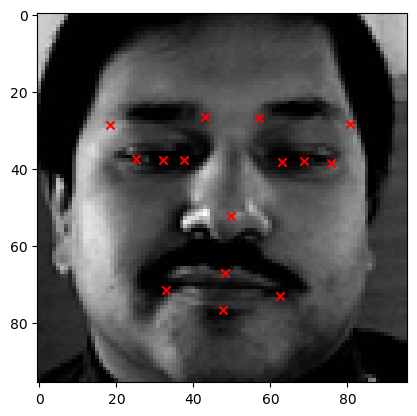

In [33]:
# visualiza una imagen aleatoria
import random

i = random.randint(0, len(X)-1)

plt.imshow(X[i].reshape(96, 96), cmap='gray')
plt.scatter(y[i][0::2], y[i][1::2], marker='x', color='red')
plt.show()

In [34]:
# normaliza y
y = y / 96

In [35]:
# programa la función create_CNN:
def create_CNN():
    '''
    La red debe aceptar una imagen en escala de grises de 96x96 como entrada y debe devolver un vector con 30 valores,
    correspondientes a las ubicaciones (horizontal y vertical) de 15 puntos clave faciales.
    '''
    model = Sequential()
    
    # He añadido estas capas porque el modelo estaba vacío y generaba un error al compilar/entrenar.
    # Lanzaba un ValueError indicando que el modelo no contiene capas definidas.
    
    model.add(Convolution2D(32, (3, 3), activation='relu', input_shape=(96, 96, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Convolution2D(64, (2, 2), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Convolution2D(128, (2, 2), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(30))

    return model

In [36]:
# Configura la arquitectura de la CNN
my_model = create_CNN()

# Compila el modelo de la CNN con un optimizador, una función de pérdida (MSE) y métricas adecuadas
my_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Entrena el modelo
history = my_model.fit(X, y, validation_split=0.2, epochs=50, batch_size=64)

# El atributo history.history contiene
# un registro de los valores de pérdida durante el entrenamiento y las métricas calculadas en
# cada época, así como los valores de pérdida y métricas de validación (si aplica).


Epoch 1/50


c:\Users\Eurobeater\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - loss: 0.0681 - mae: 0.1875 - val_loss: 0.0031 - val_mae: 0.0425
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - loss: 0.0075 - mae: 0.0684 - val_loss: 0.0013 - val_mae: 0.0268
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - loss: 0.0050 - mae: 0.0556 - val_loss: 0.0012 - val_mae: 0.0270
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - loss: 0.0041 - mae: 0.0503 - val_loss: 9.1657e-04 - val_mae: 0.0223
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - loss: 0.0034 - mae: 0.0460 - val_loss: 9.9905e-04 - val_mae: 0.0240
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - loss: 0.0032 - mae: 0.0449 - val_loss: 9.1330e-04 - val_mae: 0.0227
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - loss: 0.0030 - mae: 0.0429 - val_loss: 9.6060e-04 - val_mae: 0.0236
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - loss: 0.0026 - mae: 0.0401 - val_loss: 6.2876e-04 - val_mae: 0.0182
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/

In [37]:
#guardam el modelo
my_model.save('facialKeyPoints.keras')

In [38]:
#hagaz alguna predicción sobre el conjunto de entrenamiento:
prueba = X[0].reshape(1, 96, 96, 1)
prediccion = my_model.predict(prueba)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


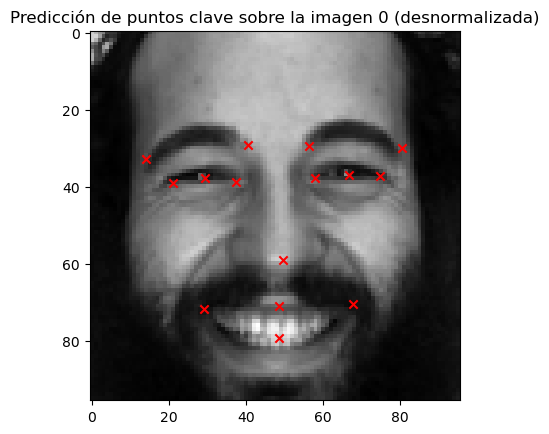

In [39]:
# muestra la prediccion
plt.imshow(X[0].reshape(96, 96), cmap='gray')

# Desnormalizar a coordenadas reales, de lo contrario no es el resultado esperado
plt.scatter(prediccion[0][0::2] * 96, prediccion[0][1::2] * 96, marker='x', color='red')
plt.title("Predicción de puntos clave sobre la imagen 0 (desnormalizada)")
plt.show()

In [40]:
# quizá el conjunto de datos sea muy reducido. Hagamos aumentación:
import numpy as np
import cv2
import random

def augment_image_and_points(image, points, img_size=96):
    """
    Aplica aumentación de datos a una imagen y sus correspondientes puntos faciales.
    
    Parámetros:
    - image: numpy array de la imagen en escala de grises (96x96).
    - points: array numpy con las coordenadas de los 15 puntos faciales (30 valores: 15 pares x, y).
    - img_size: tamaño de la imagen (por defecto, 96x96).
    
    Retorna:
    - augmented_image: imagen aumentada.
    - augmented_points: puntos faciales ajustados.
    """
    # Copiar los datos para no modificar los originales
    augmented_image = image.copy()
    augmented_points = points.copy()

    # Rotación aleatoria
    angle = random.uniform(-15, 15)  # Rotar entre -15 y 15 grados
    M = cv2.getRotationMatrix2D((img_size / 2, img_size / 2), angle, 1)
    augmented_image = cv2.warpAffine(augmented_image, M, (img_size, img_size))
    augmented_points = augmented_points.reshape(-1, 2)
    for i in range(augmented_points.shape[0]):
        x, y = augmented_points[i]
        new_x = M[0, 0] * x + M[0, 1] * y + M[0, 2]
        new_y = M[1, 0] * x + M[1, 1] * y + M[1, 2]
        augmented_points[i] = [new_x, new_y]

    # Traslación aleatoria
    max_translate = 10  # Máximo número de píxeles para trasladar
    tx = random.randint(-max_translate, max_translate)
    ty = random.randint(-max_translate, max_translate)
    M = np.float32([[1, 0, tx], [0, 1, ty]])
    augmented_image = cv2.warpAffine(augmented_image, M, (img_size, img_size))
    augmented_points[:, 0] += tx
    augmented_points[:, 1] += ty

    # Escalado aleatorio
    scale = random.uniform(0.9, 1.1)  # Escala entre 90% y 110%
    center = (img_size / 2, img_size / 2)
    M = cv2.getRotationMatrix2D(center, 0, scale)
    augmented_image = cv2.warpAffine(augmented_image, M, (img_size, img_size))
    for i in range(augmented_points.shape[0]):
        x, y = augmented_points[i]
        new_x = M[0, 0] * x + M[0, 1] * y + M[0, 2]
        new_y = M[1, 0] * x + M[1, 1] * y + M[1, 2]
        augmented_points[i] = [new_x, new_y]

    # Voltear horizontalmente con probabilidad de 50%
    if random.random() > 0.5:
        augmented_image = cv2.flip(augmented_image, 1)  # Voltear horizontalmente
        augmented_points[:, 0] = img_size - augmented_points[:, 0]

    return augmented_image, augmented_points.flatten()

# Aumentación para un conjunto de datos
def augment_data(X_train, y_train, num_augmentations=5):
    """
    Aplica aumentación de datos a un conjunto de imágenes y puntos faciales.
    
    Parámetros:
    - X_train: numpy array de imágenes (N, 96, 96, 1).
    - y_train: numpy array de puntos faciales (N, 30).
    - num_augmentations: número de imágenes aumentadas a generar por cada imagen original.
    
    Retorna:
    - X_augmented: imágenes aumentadas.
    - y_augmented: puntos faciales aumentados.
    """
    X_augmented = []
    y_augmented = []

    for i in range(len(X_train)):
        image = X_train[i].reshape(96, 96)  # Eliminar el canal para operaciones
        points = y_train[i]

        # Añadir la imagen original
        X_augmented.append(image)
        y_augmented.append(points)

        # Generar imágenes aumentadas
        for _ in range(num_augmentations):
            aug_image, aug_points = augment_image_and_points(image, points)
            X_augmented.append(aug_image)
            y_augmented.append(aug_points)

    # Convertir listas a arrays
    X_augmented = np.array(X_augmented).reshape(-1, 96, 96, 1)
    y_augmented = np.array(y_augmented)

    return X_augmented, y_augmented

# crea un conjunto de datos llamado X_train_aug, y_train_aug con las funciones anteriores
X_train_aug, y_train_aug = augment_data(X, y, num_augmentations=5)

print("Aumentado:")
print("X_train_aug:", X_train_aug.shape)
print("y_train_aug:", y_train_aug.shape)

Aumentado:
X_train_aug: (12840, 96, 96, 1)
y_train_aug: (12840, 30)


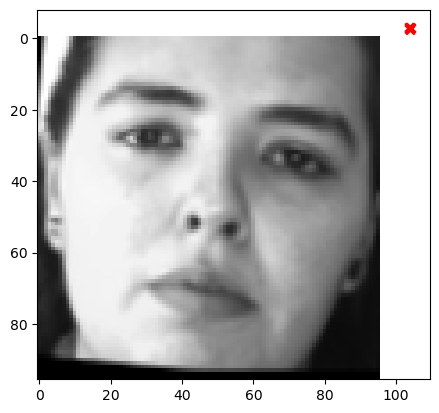

In [47]:
# muestra alguna imagen aumentada
i = random.randint(0, len(X_train_aug) - 1)

img = X_train_aug[i].reshape(96, 96)

# De nuevo, desnormalizar
pts = y_train_aug[i].reshape(-1, 2) * 96

plt.imshow(img, cmap='gray')
plt.scatter(pts[:, 0], pts[:, 1], marker='x', color='red')
plt.show()

# A veces no se printea bien la imagen

In [48]:
# Configura la arquitectura de la CNN
my_model2 = create_CNN()

#normaliza puntos y
y_train_aug = y_train_aug / 96

# Compila el modelo de la CNN con un optimizador, una función de pérdida y métricas adecuadas
my_model2.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Entrena el modelo
# history2 = my_model2.fit(X_train_aug, y_train_aug, validation_split=0.2, epochs=50, batch_size=64)
history2 = my_model2.fit(X_train_aug, y_train_aug, validation_split=0.2, epochs=5, batch_size=64)

Epoch 1/5


c:\Users\Eurobeater\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


161/161 ━━━━━━━━━━━━━━━━━━━━ 22s 126ms/step - loss: 0.0015 - mae: 0.0114 - val_loss: 1.1905e-05 - val_mae: 0.0027
Epoch 2/5
161/161 ━━━━━━━━━━━━━━━━━━━━ 20s 125ms/step - loss: 1.2254e-05 - mae: 0.0027 - val_loss: 1.0403e-05 - val_mae: 0.0024
Epoch 3/5
161/161 ━━━━━━━━━━━━━━━━━━━━ 19s 117ms/step - loss: 1.0430e-05 - mae: 0.0024 - val_loss: 9.3787e-06 - val_mae: 0.0022
Epoch 4/5
161/161 ━━━━━━━━━━━━━━━━━━━━ 19s 118ms/step - loss: 9.4896e-06 - mae: 0.0022 - val_loss: 9.1135e-06 - val_mae: 0.0021
Epoch 5/5
161/161 ━━━━━━━━━━━━━━━━━━━━ 19s 116ms/step - loss: 8.6831e-06 - mae: 0.0021 - val_loss: 8.2773e-06 - val_mae: 0.0020


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


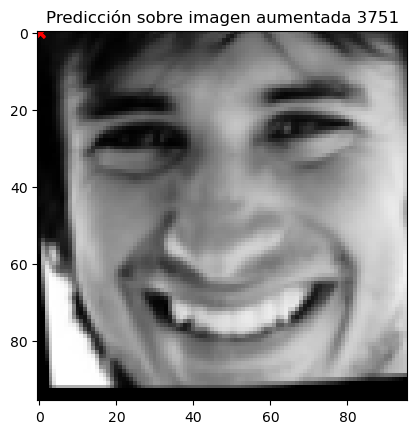

In [49]:
# haz predicciones y muestra algún resultado
i = random.randint(0, len(X_train_aug) - 1)

img = X_train_aug[i].reshape(1, 96, 96, 1)
pred = my_model2.predict(img)
pred_points = pred[0].reshape(-1, 2) * 96  # desnormalizar

plt.imshow(X_train_aug[i].reshape(96, 96), cmap='gray')
plt.scatter(pred_points[:, 0], pred_points[:, 1], marker='x', color='red')
plt.title(f"Predicción sobre imagen aumentada {i}")
plt.show()

In [50]:
# carga los datos de test
X_test,y_test=load_data(True)
#y_test no tiene datos de coordenadas, hay que "predecirlas"


In [51]:
# realiza las predicciones sobre el conjunto de test y muestra algún resultado


In [52]:
# guarda el modelo 2
# my_model2.save('modelos/facialKeyPoints_augmented.keras')
my_model2.save('facialKeyPoints_augmented.keras')
